## Checkpoint 13

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout

from nn_utils import plot_learning_curve
DIR = os.getcwd()

#### Exercise #1 (1 point):
Open the CSV file, and feed the data into a ```pandas.core.frame.DataFrame``` object. Carry out the usual sanity checks (```pandas.core.frame.DataFrame.head(5)```), and determine if data-cleaning is necessary (```pandas.core.frame.DataFrame.dropna(inplace= True)```). Make sure all variables have the same number of entries before proceeding. Plot 1D distributions for the all 6 variables listed in Table 1, in log scale (y-axis). Do not normalise the distributions. You can use a loop over the (5 input plus 1 output) features to simplify the code, and you can ignore the units on the x-axis.

In [27]:
# Reading the data
data = pd.read_csv(os.path.join(DIR, 'numu_energy_studies.csv'))
data.dropna(inplace=True)
data.head()

,Unnamed: 0,i,neutrinoE,trueKE,recoE_lookup,total_PMTs_hits2,total_hits2,total_ring_PEs2,pot_length2,hits_pot_length2,recoDWallR2,recoDWallZ2,lambda_max_2,recoDWall_2,recoToWall_2,vtxTrackBias_2
0,0,0,664.541,236.327,22.35380,0.000000,0.023325,0.00000,0.662787,0.003754,0.003389,0.458415,0.650854,0.003389,0.220977,-0.011905
1,1,3,400.551,186.765,2.46971,0.000000,0.010075,0.00000,0.662787,0.001621,0.003389,0.458415,0.405903,0.003389,0.220977,-2.269040
2,2,4,633.353,448.481,409.95400,0.308444,0.080400,0.13070,0.531171,0.016146,0.035389,0.753969,0.537975,0.035389,0.494926,0.024453
3,3,7,845.921,586.647,37.83740,0.000000,0.011950,0.00000,0.918554,0.001388,0.042498,0.083664,0.830098,0.042498,0.805578,-0.007114
4,4,9,1323.140,963.822,1408.07000,0.111333,0.142300,0.26265,0.093641,0.162093,0.616305,0.164307,0.092105,0.358487,0.135845,-0.004307


In [28]:
# Defining the input and output parameters
inputs = ['total_hits2', 'total_ring_PEs2', 'recoDWallR2', 'recoDWallZ2', 'lambda_max_2']
output = ['trueKE']
theKeys = inputs + output

# Make new dataframe with only the keys we want
data = pd.DataFrame(data, columns=theKeys)
data.head()

,total_hits2,total_ring_PEs2,recoDWallR2,recoDWallZ2,lambda_max_2,trueKE
0,0.023325,0.00000,0.003389,0.458415,0.650854,236.327
1,0.010075,0.00000,0.003389,0.458415,0.405903,186.765
2,0.080400,0.13070,0.035389,0.753969,0.537975,448.481
3,0.011950,0.00000,0.042498,0.083664,0.830098,586.647
4,0.142300,0.26265,0.616305,0.164307,0.092105,963.822


In [29]:
theKeys

['total_hits2',
 'total_ring_PEs2',
 'recoDWallR2',
 'recoDWallZ2',
 'lambda_max_2',
 'trueKE']

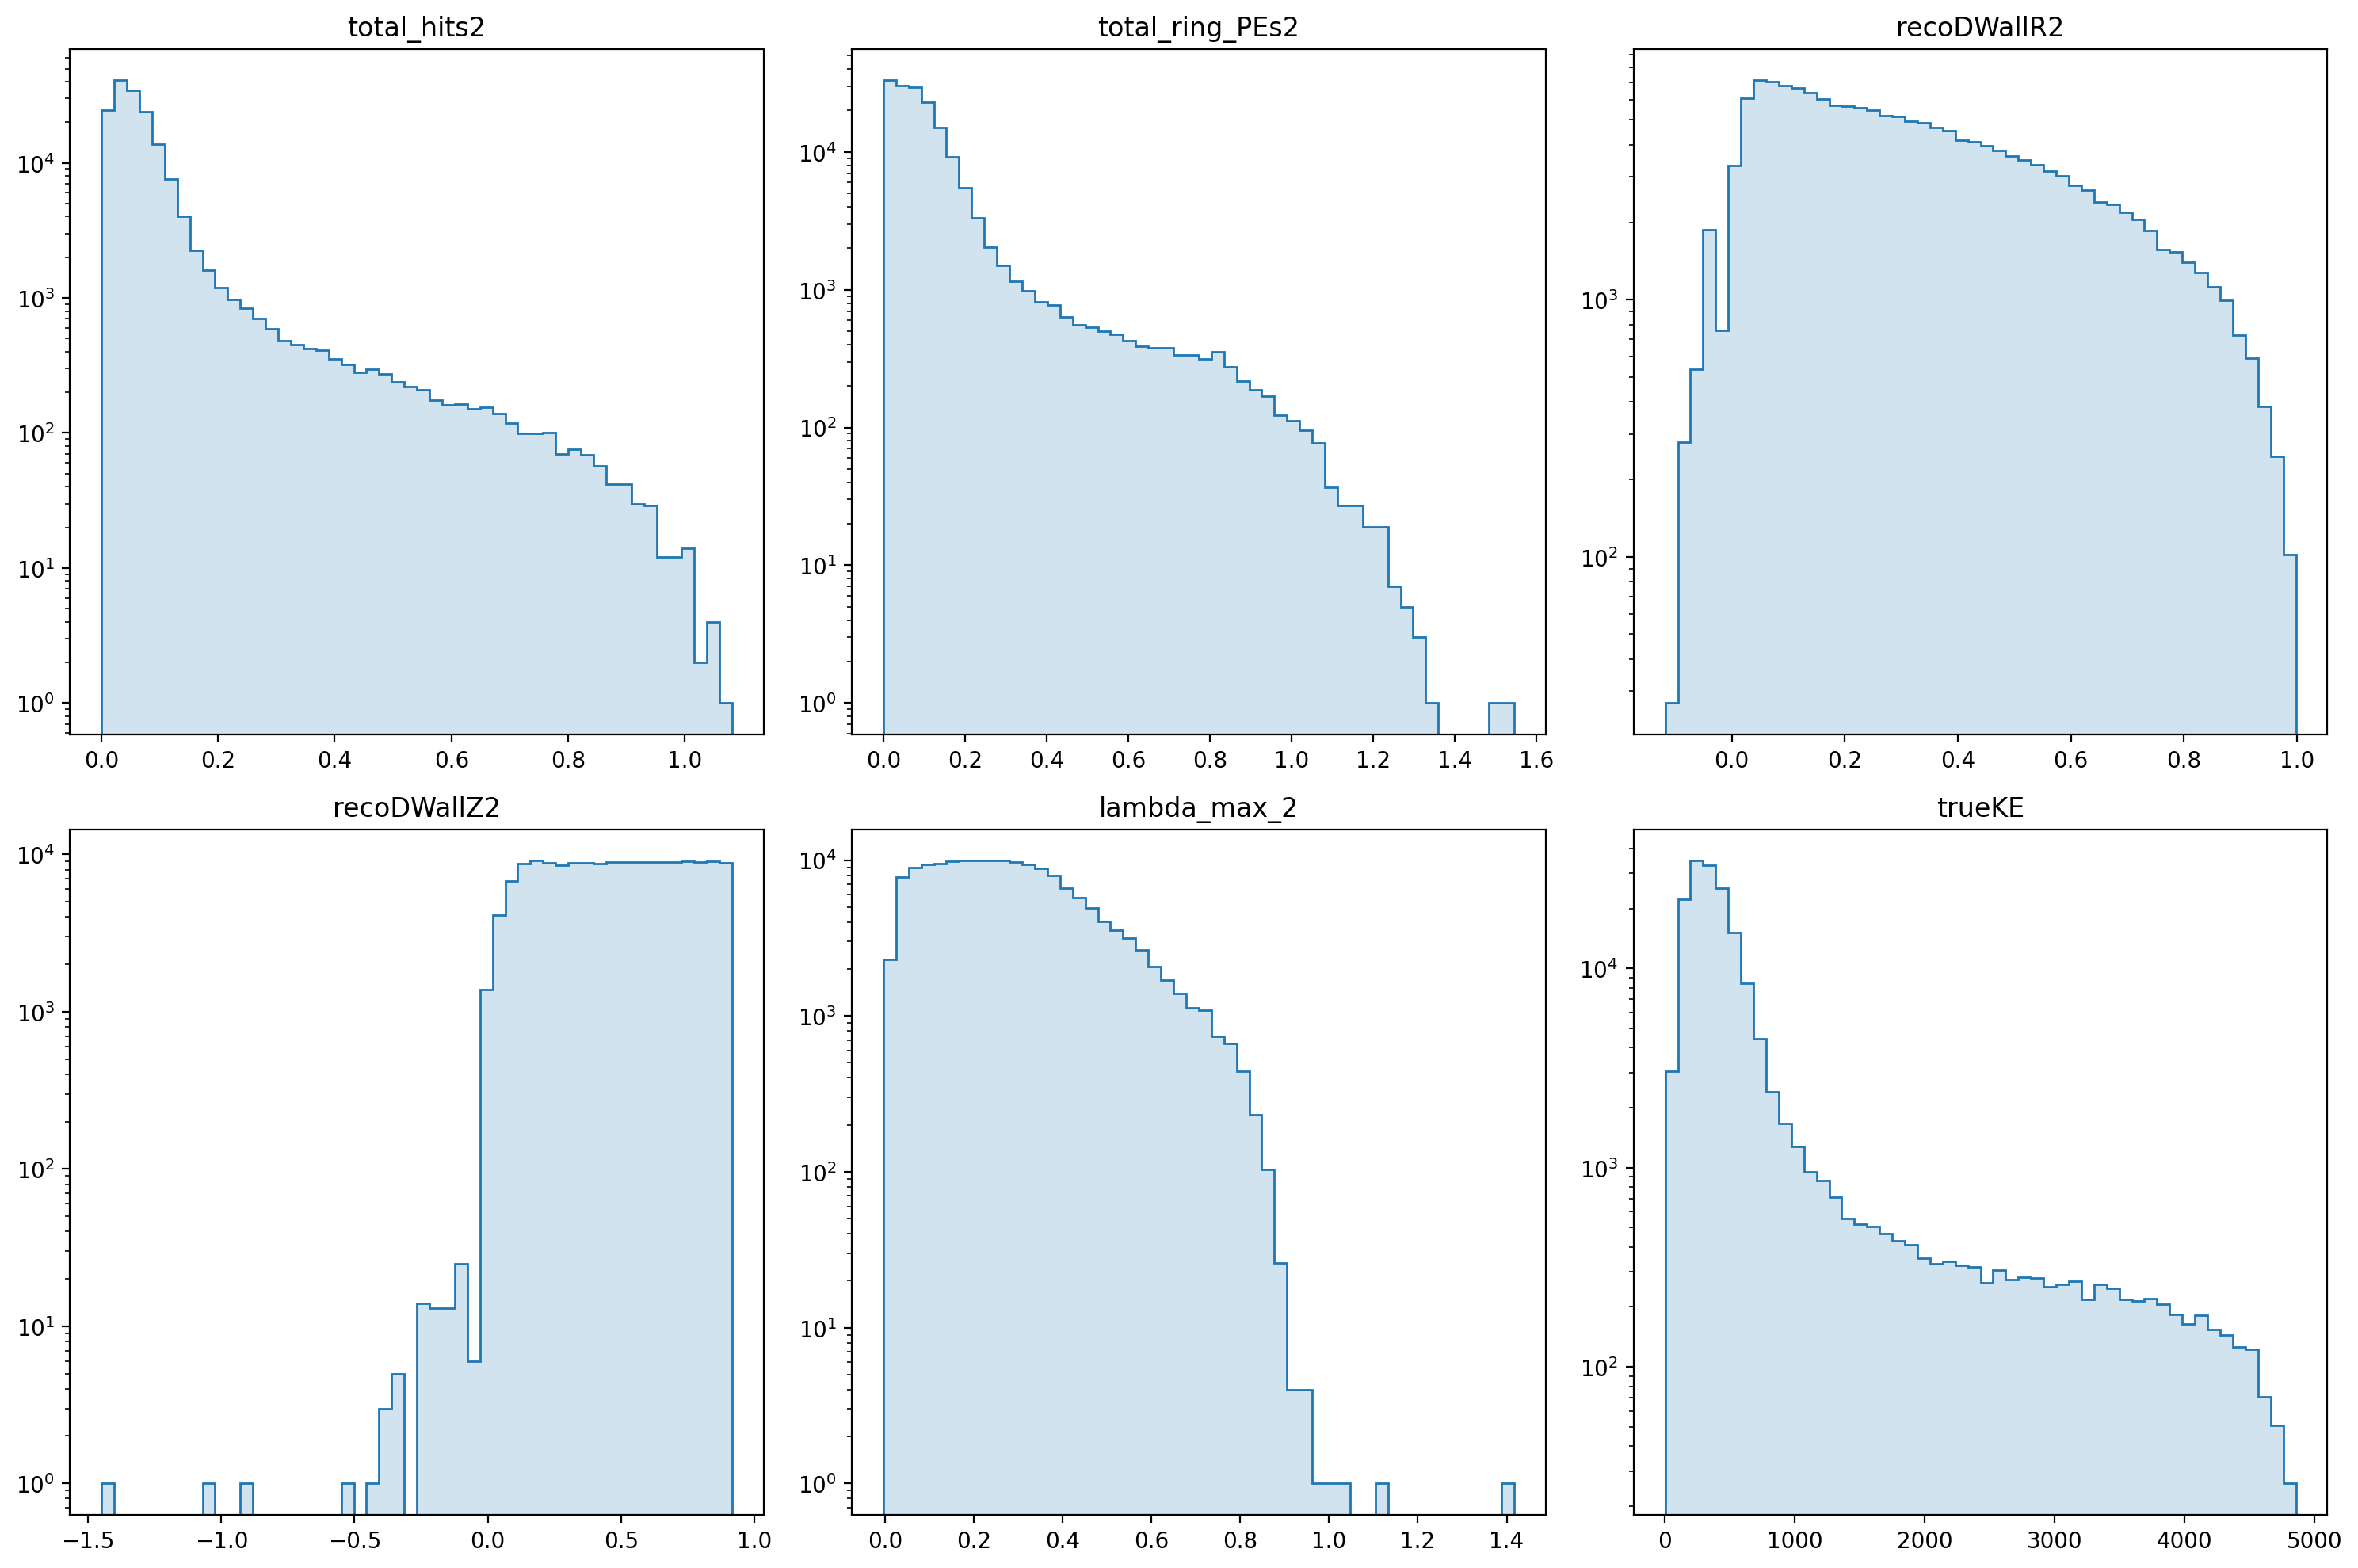

In [30]:
# Plot histograms of the input and output parameters
fig, ax = plt.subplots(2, 3, figsize=(15, 10), dpi=200)

ax = ax.ravel()
for i in range(len(theKeys)):
    ax[i].hist(data[theKeys[i]], bins=50, histtype='step', color='tab:blue')
    ax[i].hist(data[theKeys[i]], bins=50, alpha=0.2, color='tab:blue')
    ax[i].set_title(theKeys[i])
    ax[i].set_yscale('log')
    
plt.tight_layout()
plt.show()

#### Exercise #2 (4 points):
Create a new dataframe containing only the 5 input and 1 output features of interest.Split the new dataset into training (70%) and test (30%) subsets:

(a) (2 points) Write a function implementing a NN, as we have seen in previous check-points. Use a reasonable number of layers and nodes. Implement the usual callback hook that exits the NN optimisation when the classification converges.

Demonstrate the good performance by running a cross-validation. Don’t spend too muchtime optimising the architecture, aim for a R2 score of higher than 70-75%.

(b) (2 points) Use method fit on the model you have implemented in the function, usingthe training dataset for the fitting, and the test dataset for validation: validation data= (test data, test target).Use array History.history[’loss’] to plot the evolution of the loss-function (y-axis inlog-scale) as a function of the epoch. You may use function nn utils.lossplot or writeyour own.Use method predict to get an array of predicted muon-energy values using test data.Compare it with test target by creating a “predicted” (y-axis) vs. “actual” (x-axis)scatter plot of muon energy values

In [31]:
sc = StandardScaler()

input_data = data[inputs].values
input_data = sc.fit_transform(input_data)

target = data[output].values
target = sc.fit_transform(target)


# Set the random seed
Answer_to_all_questions = 42

# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(input_data, target, test_size=0.3, random_state=Answer_to_all_questions)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(114514, 5) (114514, 1) (49078, 5) (49078, 1)


In [32]:
batchSize = 500
N_epochs = 50
num_nodes = 20

num_inputs = input_data.shape[1]
num_outputs = 1

In [33]:
def my_model():
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_nodes, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_outputs, kernel_initializer='normal'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam') #metrics=['accuracy']
    
    return model

model = my_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 20)                120       
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_45 (Dense)            (None, 20)                420       
                                                                 
 dense_46 (Dense)            (None, 20)                420       
                                                                 
 dense_47 (Dense)            (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [34]:
callbacks_ = [
    # if we don ’t have an increase of the accuracy for 10 epochs, terminate training. 
    EarlyStopping(verbose =True, patience=10, monitor='loss'),
    # Always make sure that we’re saving the model weights with the best accuracy.
    ModelCheckpoint('model.h5', monitor='loss', verbose=0, save_best_only=True, mode='max')
    ]

In [35]:
np.random.seed(Answer_to_all_questions)

estimators = []
estimators.append(('mlp', KerasRegressor(build_fn=my_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))
pipeline = Pipeline(estimators)

kfold = KFold(n_splits=10 , random_state=Answer_to_all_questions, shuffle=True)
results = cross_val_score(pipeline, input_data, target, cv=kfold, fit_params={'mlp__callbacks': callbacks_}, scoring='r2')

print("Result: %.2f %s %.2f " %(results.mean(), u"\u00B1", results.std()))

Epoch 1/50


C:\Users\blybe\AppData\Local\Temp\ipykernel_25092\3188448500.py:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(('mlp', KerasRegressor(build_fn=my_model, epochs=N_epochs, batch_size=batchSize, verbose=1)))


295/295 [==============================] - 1s 2ms/step - loss: 0.4791
Epoch 2/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2762
Epoch 3/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2665
Epoch 4/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2579
Epoch 5/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2510
Epoch 6/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2472
Epoch 7/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2437
Epoch 8/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2403
Epoch 9/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2373
Epoch 10/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2342
Epoch 11/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2323
Epoch 12/50
295/295 [==============================] - 1s 2ms/step - loss: 0.2313
Epoch 13/50
295/295 [===============

In [ ]:
history = model.fit(train_data, train_target, epochs=N_epochs, batch_size=batchSize, verbose=1, callbacks=callbacks_, validation_data=(test_data, test_target))

Epoch 1/50


230/230 [==============================] - 1s 3ms/step - loss: 583698.5625 - val_loss: 370877.6250
Epoch 2/50
230/230 [==============================] - 1s 2ms/step - loss: 308025.7812 - val_loss: 270576.1562
Epoch 3/50
230/230 [==============================] - 1s 2ms/step - loss: 221459.0625 - val_loss: 145876.0625
Epoch 4/50
230/230 [==============================] - 1s 2ms/step - loss: 121202.1875 - val_loss: 105098.5938
Epoch 5/50
230/230 [==============================] - 1s 2ms/step - loss: 110260.5859 - val_loss: 103018.7422
Epoch 6/50
230/230 [==============================] - 1s 2ms/step - loss: 109465.2656 - val_loss: 102158.0312
Epoch 7/50
230/230 [==============================] - 1s 2ms/step - loss: 108959.6641 - val_loss: 101675.1406
Epoch 8/50
230/230 [==============================] - 1s 3ms/step - loss: 107921.3984 - val_loss: 101126.6016
Epoch 9/50
230/230 [==============================] - 1s 2ms/step - loss: 107683.0078 - val_loss: 100619.6406
Epoch 10/50
230/230 [

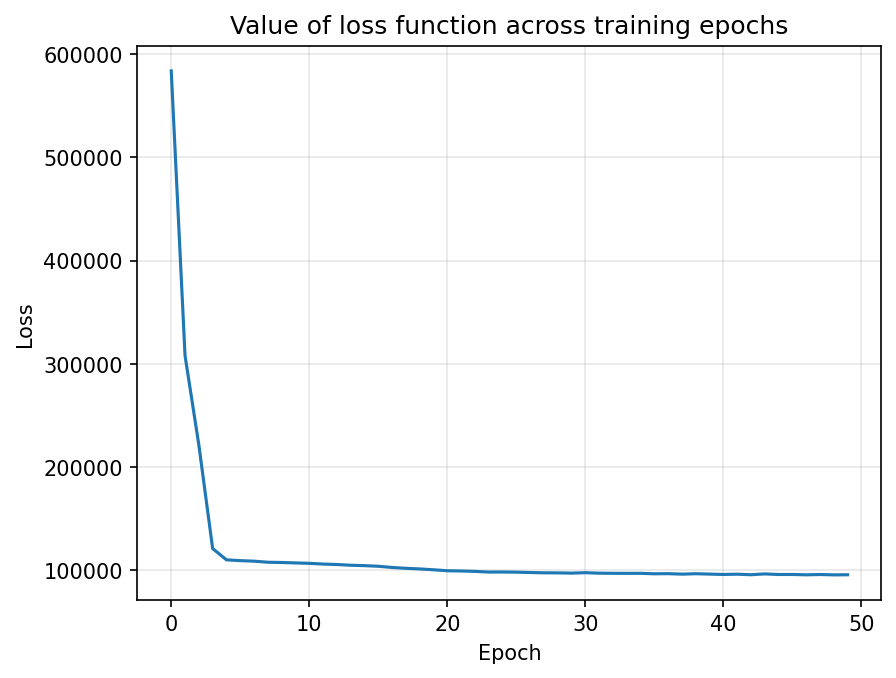

In [ ]:
plt.figure(dpi=150)

plt.plot(history.history['loss'])

plt.title('Value of loss function across training epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=0.3)
plt.show()

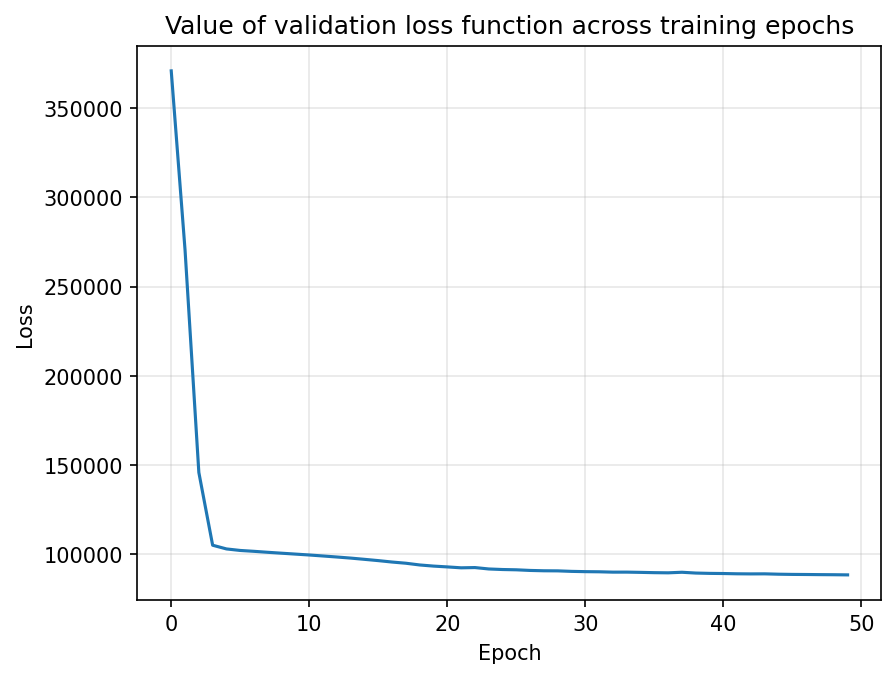

In [ ]:
plt.figure(dpi=150)

plt.plot(history.history['val_loss'])

plt.title('Value of validation loss function across training epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(alpha=0.3)
plt.show()

In [ ]:
model.load_weights('model.h5')

In [ ]:
predict_target = model.predict(test_data)

1534/1534 [==============================] - 2s 1ms/step


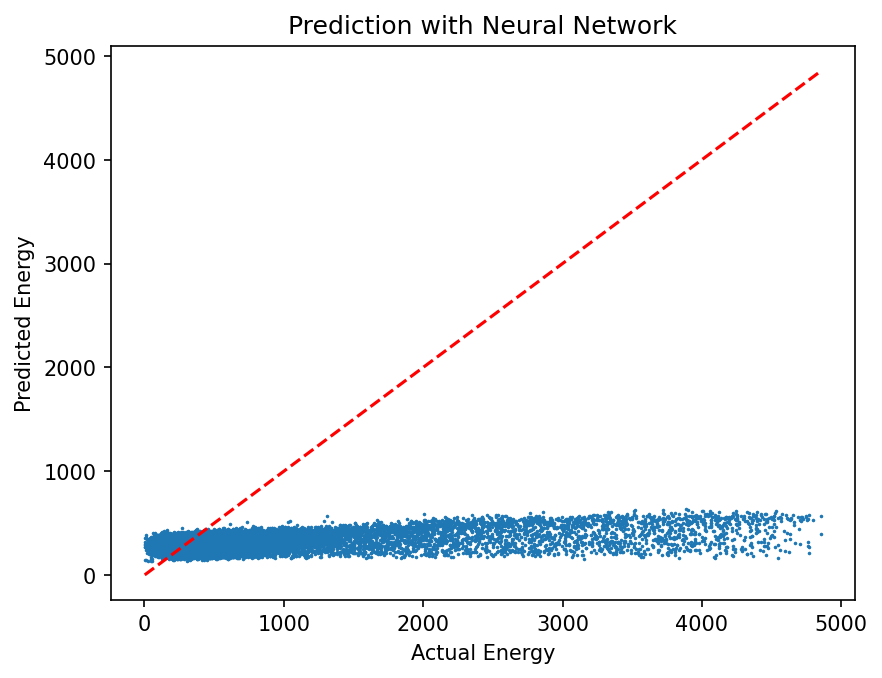

In [ ]:
plt.figure(dpi=150)
plt.scatter(test_target, predict_target, s=0.5)
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)], '--r')

plt.title('Prediction with Neural Network')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.show()

#### Exercise #3 (5 points):
(a) (1 point) Try to get a quick result by using a GBRT with the default parameters.
Use method ```GradientBoostingRegressor.score``` to get two R2 scores, one for the training and one for the test datasets. If these two numbers differ significantly, you are probably suffering from overfitting.

How do these scores compare with the performance you got for the NN regressor?

(b) (2 points) We will be now doing a proper optimisation by using a grid-search of theregressor parameters and cross-validation in order to identify the optimal regressor. Use the syntax below to feed the regressor with sets of various parameter values. <br>
Hint: this can result into a slow optimisation (e.g. up to 1-2 hours, or more). Playwith a small number of values for the parameter grid first, then slowly work yourway towards an optimal point. Make sure the machine you are running on can han-dle n jobs > 1 before starting the optimisation. You may also want to use the newerclass ```HalvingGridSearchCV``` instead of ```GridSearchCV```.
<br> <br>
Use function nn utils.plot learning curve to plot the performance of the optimised regressor (```classifier.best_estimator_```) for the training and the test datasets.
<br> <br>
(c) (2 points) Create a new GBRT regressor with the parameters as determined by ```classifier.best_estimator_```. Run method cross val score on the test dataset and cross-validation, and determine the R^2 score with its standard deviation. 
<br> <br>
Use method ```fit``` on the training dataset, and ```predict``` on the test dataset. Get the array of predicted muon-energy values using test data. Compare it with test target bycreating a "predicted" ($y$-axis) vs. "actual" ($x$-axis) scatter plot of muon energy values.
<br> <br>
Use method ```feature_importances_``` on the optimised regressor to get an insight asto which input features have the greatest impact on the predictive power of the algorithm. Order the input features according to their weight. Create a bar chart(```matplotlib.pyplot.bar```) with the ranked weights of the 5 input features
<br>
<br>
(a)

In [ ]:
gbr0 = GradientBoostingRegressor(n_estimators=100)
gbr0.fit(train_data, train_target.ravel())

KeyboardInterrupt: 

In [ ]:
print("The training dataset has a score of", gbr0.score(train_data, train_target))

The training dataset has a score of 0.7830727956686763


In [ ]:
print("The test dataset has a score of", gbr0.score(test_data, test_target))

The test dataset has a score of 0.781797050479113


These values are slightly lower compared to the NN regressor.
<br>
<br>
(b)

In [ ]:
param_grid_ = {'n_estimators':[100],
               'learning_rate': [0.1 , 0.05], 
               'max_depth': [5 , 10],
               'min_samples_leaf': [50 ,100],
               }
# jobs to run in parallel
njobs_ = -1
np.random.seed(Answer_to_all_questions)

gbr = GradientBoostingRegressor()
classifier = GridSearchCV(estimator=gbr, cv=kfold, param_grid=param_grid_, n_jobs=njobs_, verbose=1)
classifier.fit(train_data, train_target.ravel())

print(" Best estimator:", classifier.best_estimator_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
 Best estimator: GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)


<Figure size 960x720 with 0 Axes>

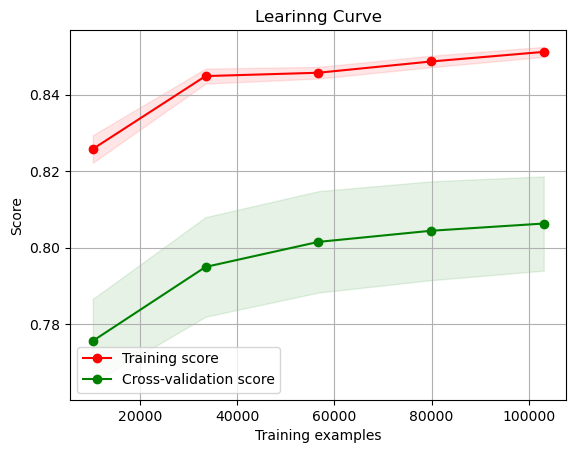

In [ ]:
plt.figure(dpi=150)
plot_learning_curve(classifier.best_estimator_, 'Learinng Curve', train_data, train_target.ravel(), cv=kfold, n_jobs=njobs_)
plt.show()

(c)

In [ ]:
gbr1 = classifier.best_estimator_ #GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)
val_score = cross_val_score(gbr1, test_data, test_target.ravel(), cv=kfold, scoring='r2')

print("Result of the GBR: %.2f %s %.2f " %(val_score.mean(), u"\u00B1", val_score.std()))

Result of the GBR: 0.80 ± 0.02 


In [ ]:
# run fit on the training dataset with this estimator
gbr1.fit(train_data, train_target.ravel())

GradientBoostingRegressor(learning_rate=0.05, max_depth=10, min_samples_leaf=50)

In [ ]:
# Predict on the test dataset
predict_target_gbr1 = gbr1.predict(test_data)

/tmp/ipykernel_230466/1053656595.py:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


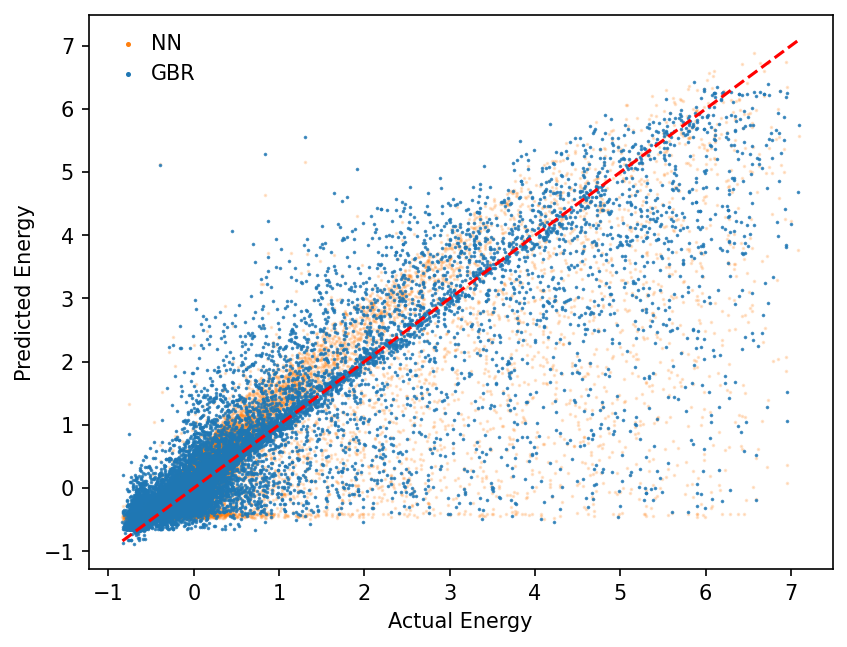

In [ ]:
# Compare with the test_target with scatter plot
plt.figure(dpi=150)
plt.scatter(test_target, predict_target, s=0.5, color='tab:orange', alpha=0.2, label='NN')
plt.scatter(test_target, predict_target_gbr1, s=0.5, color='tab:blue', alpha=0.8, label='GBR')
plt.plot([min(test_target), max(test_target)], [min(test_target),  max(test_target)], '--r')

leg = plt.legend(frameon=False, handletextpad=0.1, markerscale=2)
for lh in leg.legendHandles:
    lh.set_alpha(1)
    
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.show()

In [ ]:
feauture_importance = gbr1.feature_importances_

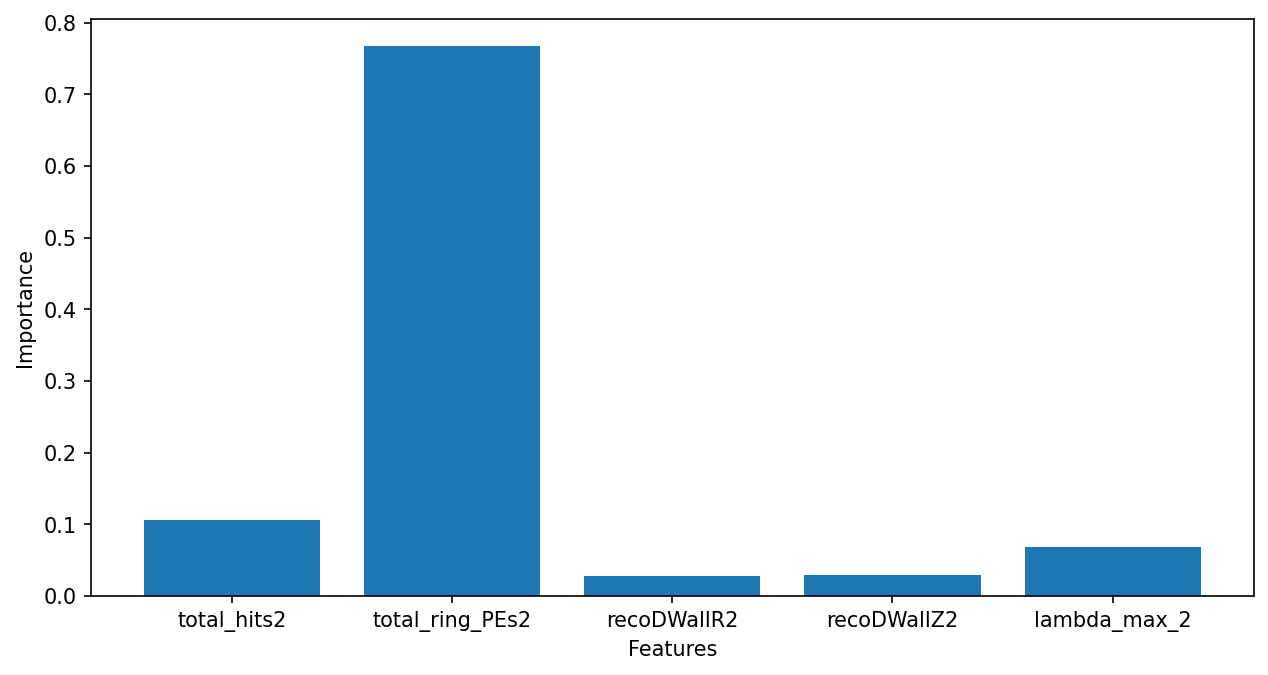

In [ ]:
plt.figure(dpi=150, figsize=(10, 5))
# create a bar chart
plt.bar(range(len(feauture_importance)), feauture_importance)
plt.xticks(range(len(feauture_importance)), inputs)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()